## 库，数据类

In [2]:
import re
import json
from datetime import datetime
from collections import defaultdict
from typing import List, Dict

class EpochData:
    def __init__(self, epoch: int):
        self.epoch = epoch
        self.time_cost = 0.0          # 整个epoch的时间消耗（秒）
        self.avg_loss = 0.0           # 整个epoch的平均损失
        self.steps = []               # 每个step的信息字典列表

    def add_step(self, step: int, step_time_cost: float, loss: float):
        """添加单个step的信息"""
        self.steps.append({
            "step": step,
            "time_cost": step_time_cost,
            "loss": loss
        })

    def to_json(self) -> str:
        """将对象转换为JSON字符串"""
        return json.dumps({
            "epoch": self.epoch,
            "time_cost": self.time_cost,
            "avg_loss": self.avg_loss,
            "steps": self.steps
        }, indent=2)

    @classmethod
    def from_json(cls, json_str: str) -> "EpochData":
        """从JSON字符串创建对象"""
        data = json.loads(json_str)
        epoch_data = cls(data["epoch"])
        epoch_data.time_cost = data["time_cost"]
        epoch_data.avg_loss = data["avg_loss"]
        epoch_data.steps = data["steps"]
        return epoch_data

## 提取日志

In [3]:
def parse_log(log_text: str) -> List[EpochData]:
    """解析训练日志并返回EpochData对象列表"""
    lines = [line.strip() for line in log_text.split('\n') if line.strip()]
    pattern_step = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}).*Epoch (\d+) Step (\d+).*Loss: ([\d.]+)')
    pattern_complete = re.compile(r'.*Epoch (\d+) completed.*time cost: ([\d.]+)s')
    pattern_avg_loss = re.compile(r'.*Average loss: ([\d.]+)')
    epochs = defaultdict(lambda: {'steps': [], 'end_time': None})
    
    def parse_time(timestamp):
        return datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S,%f')
    
    # 第一遍：收集所有step和epoch完成信息
    current_epoch = None

    for line in lines:
        # 解析step信息
        step_match = pattern_step.match(line)
        if step_match:
            timestamp, epoch, step, loss = step_match.groups()
            current_epoch = int(epoch)
            step_data = {
                'timestamp': parse_time(timestamp),
                'step': int(step),
                'loss': float(loss)
            }
            epochs[current_epoch]['steps'].append(step_data)
            continue
        # 解析epoch完成信息
        complete_match = pattern_complete.match(line)
        if complete_match:
            epoch, time_cost = complete_match.groups()
            epoch = int(epoch)
            current_epoch = epoch
            epochs[epoch]['time_cost'] = float(time_cost)
            epochs[epoch]['completed'] = True
            continue
        # 解析平均损失
        avg_match = pattern_avg_loss.match(line)
        if avg_match and current_epoch:
            avg_loss = float(avg_match.group(1))
            epochs[current_epoch]['avg_loss'] = avg_loss

    # 第二遍：计算每个step的时间消耗并创建EpochData对象
    results = []
    for epoch_num, data in epochs.items():
        if 'avg_loss' not in data or 'time_cost' not in data:
            continue
        
        epoch_data = EpochData(epoch_num)
        epoch_data.time_cost = data['time_cost']
        epoch_data.avg_loss = data['avg_loss']
        # 计算每个step的时间消耗
        steps_sorted = sorted(data['steps'], key=lambda x: x['step'])
        prev_time = None
        for step_info in steps_sorted:
            current_time = step_info['timestamp']
            if prev_time:
                time_cost = (current_time - prev_time).total_seconds()
                epoch_data.add_step(
                    step=step_info['step'],
                    step_time_cost=time_cost,
                    loss=step_info['loss']
                )
            prev_time = current_time
        results.append(epoch_data)
    
    return sorted(results, key=lambda x: x.epoch)

## 整理，绘制

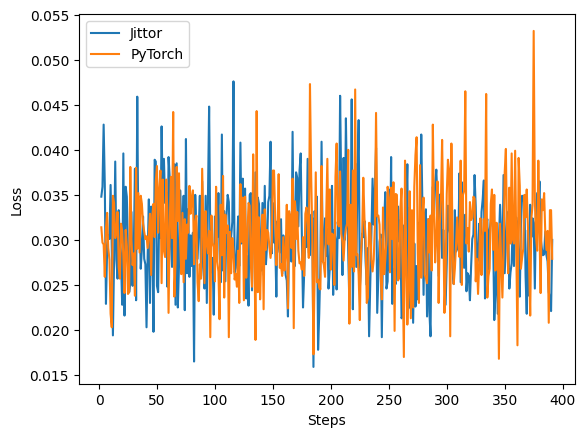

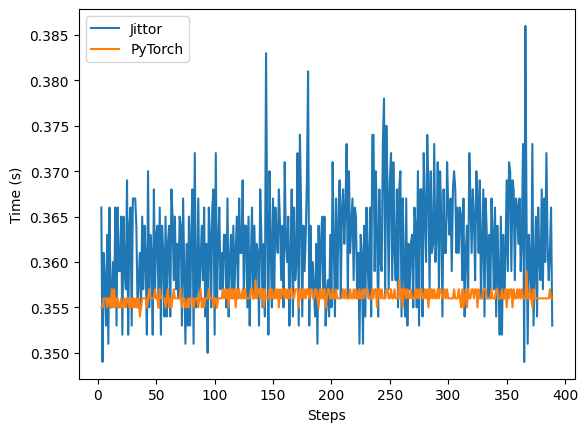

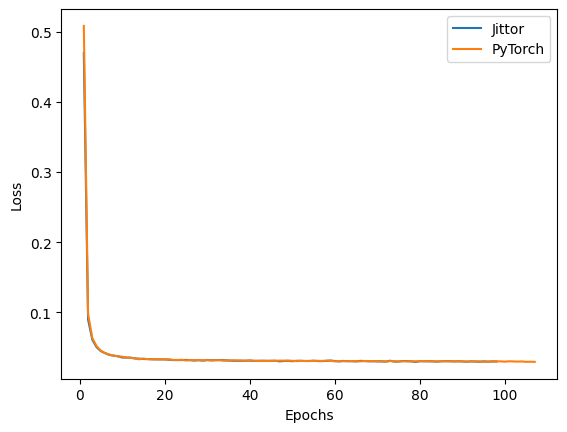

Jittor average time: 142.4263265306123
PyTorch average time: 139.2600934579439


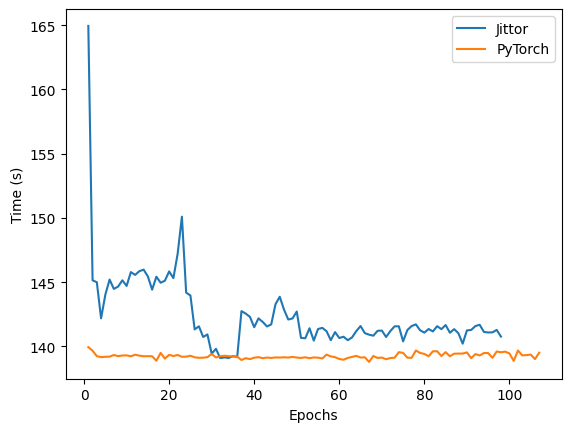

In [8]:
import matplotlib.pyplot as plt

with open("jittor_ver/logs/20250602-210449/log.txt", "r") as f:
    log_jittor = f.read()
records_jittor = parse_log(log_jittor)

# with open("/root/autodl-tmp/DMs/ddpm-ddim/pytorch-ver/logs/train_20250526-121536/log.txt", "r") as f:
#     log_pytorch = f.read()
with open("pytorch_ver/logs/20250602-205837/log.txt", "r") as f:
    log_pytorch = f.read()
records_pytorch = parse_log(log_pytorch)


def plot_step_loss(jittor_steps, jittor_losses, pytorch_steps, pytorch_losses):
    plt.plot(jittor_steps, jittor_losses, label="Jittor")
    plt.plot(pytorch_steps, pytorch_losses, label="PyTorch")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_step_time(jittor_steps, jittor_times, pytorch_steps, pytorch_times):
    plt.plot(jittor_steps, jittor_times, label="Jittor")
    plt.plot(pytorch_steps, pytorch_times, label="PyTorch")
    plt.xlabel("Steps")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()


def plot_epoch_loss(jittor_epochs, jittor_losses, pytorch_epochs, pytorch_losses):
    plt.plot(jittor_epochs, jittor_losses, label="Jittor")
    plt.plot(pytorch_epochs, pytorch_losses, label="PyTorch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_epoch_time(jittor_epochs, jittor_times, pytorch_epochs, pytorch_times):
    plt.plot(jittor_epochs, jittor_times, label="Jittor")
    plt.plot(pytorch_epochs, pytorch_times, label="PyTorch")
    # print average time
    print("Jittor average time:", sum(jittor_times) / len(jittor_times))
    print("PyTorch average time:", sum(pytorch_times) / len(pytorch_times))
    plt.xlabel("Epochs")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()


epoch = 80
plot_step_loss(
    [x['step'] for x in records_jittor[epoch].steps],
    [x['loss'] for x in records_jittor[epoch].steps],
    [x['step'] for x in records_pytorch[epoch].steps],
    [x['loss'] for x in records_pytorch[epoch].steps]
)
plot_step_time(
    [x['step'] for x in records_jittor[epoch].steps[1:-2]],
    [x['time_cost'] for x in records_jittor[epoch].steps[1:-2]],
    [x['step'] for x in records_pytorch[epoch].steps[1:-2]],
    [x['time_cost'] for x in records_pytorch[epoch].steps[1:-2]]
)
plot_epoch_loss(
    [x.epoch for x in records_jittor],
    [x.avg_loss for x in records_jittor],
    [x.epoch for x in records_pytorch],
    [x.avg_loss for x in records_pytorch]
)
plot_epoch_time(
    [x.epoch for x in records_jittor],
    [x.time_cost for x in records_jittor],
    [x.epoch for x in records_pytorch],
    [x.time_cost for x in records_pytorch]
)